In [1]:
import tensorflow as tf
import numpy as np
import os
from joblib import load
from utils.plot_map import plot_map
from utils.model_analysis import plot_yearly_analysis, plot_seasonal_analysis, plot_timeseries_analysis, plot_shap_over_time
from utils.data_loader import load_as_maps
from utils.u_next_layer import ShiftedBlock, OverlapPatchEmbed

/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# IMPORT DATA

# specify path to test data
test_data_path = "../../data/preprocessed_exp1"

start_year = 2015
end_year = 2015

start_index = (start_year-1958)*12+1
end_index = (end_year-1957)*12+1

# load test data
feature_files = [os.path.join(test_data_path, f"{i}_features.npy") for i in range(start_index, end_index)]
target_files = [os.path.join(test_data_path, f"{i}_targets.npy") for i in range(start_index, end_index)]

features = np.stack([np.load(fp) for fp in feature_files])
targets = np.stack([np.load(fp) for fp in target_files])

targets = targets[..., 3]


In [11]:
# load model
model_path = "../../outputs/mlp/2025-09-12_21-12"
model = tf.keras.models.load_model(model_path + "/model.keras")

# Save original shape for reshaping later
target_shape = targets.shape 
# features_reduced = features

# Flatten all but the last dimension
n_samples, h, w, n_features = features.shape
X_test_reshaped = features.reshape(-1, n_features)

mask = X_test_reshaped[:, 11] == 1

X_test_reshaped = np.delete(X_test_reshaped, 15, axis=-1)
X_test_reshaped = np.delete(X_test_reshaped, 12, axis=-1)
X_test_reshaped = np.delete(X_test_reshaped, 11, axis=-1)

# load scaler
feature_scaler = load(model_path + '/scaler.pkl')

# apply scaler
X_test_flat = feature_scaler.transform(X_test_reshaped)
X_test = X_test_flat

# X_test = X_test_flat.reshape(n_samples, h, w, n_features)

print("X_test shape:", X_test.shape)

X_test shape: (721440, 13)


In [5]:
# load model
model_path = "../../outputs/u-net/2025-09-15_09-27"
model = tf.keras.models.load_model(model_path + "/model.keras")

features = np.delete(features, 15, axis=-1)
features = np.delete(features, 14, axis=-1)
features = np.delete(features, 13, axis=-1)
features = np.delete(features, 12, axis=-1)

print(targets.shape)
print(features.shape)

mask = features[..., 11] == 0 
# setting this feature to zero for land points because it had some random values
features[..., 5][mask] = 0 

mask = features[0,:,:, 11] == 1

X_test = features

scaler = load(model_path + '/scaler.pkl')
# scaler = MinMaxScaler()
n_samples, h, w, n_features = X_test.shape
X_test_flat = X_test.reshape(-1,n_features)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_test = X_test_scaled_flat.reshape(n_samples, h, w, n_features)

(12, 167, 360)
(12, 167, 360, 12)


/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_pred = model.predict(X_test)
pred = test_pred.reshape(-1)
truth = targets.reshape(-1)

# test_pred = target_scaler.inverse_transform(test_pred)

# computiung mse and mae for ocean points only

# just for U-Next
mask = X_test.reshape(-1,12)
mask = mask[:, 11] == 1

pred = pred[mask]
truth = truth[mask]

mse = mean_squared_error(pred, truth)
mae = mean_absolute_error(pred, truth)
print(f"Mean Squared Error: {mse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

45090/45090 ━━━━━━━━━━━━━━━━━━━━ 34s 748us/step


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1442880 but corresponding boolean dimension is 1563120

In [70]:
target_shape = targets.shape 
mask = features[0,:,:, 11] == 1

test_reshaped = test_pred.reshape(target_shape)
test_reshaped = test_reshaped * mask
absolute_error = np.abs(test_reshaped - targets)
mean_error = np.mean(absolute_error, axis=0)
squared_error = (test_reshaped - targets) ** 2
rmse = np.sqrt(np.mean(squared_error, axis=0)) 

ValueError: cannot reshape array of size 4328640 into shape (24,167,360)

In [15]:
# plot feature importance over time per basin
X_test_reshaped = X_test.reshape((12,167,360,13))

feature_names = ['SST', 'SAL', 'ice_frac', 'mixed_layer_depth', 'heat_flux_down', 'water_flux_up', 'stress_X', 'stress_Y', 'currents_X', 'currents_Y',
            'month','nav_lat', 'nav_lon']

mask = features[0,:,:, 11] == 1


mean_abs_shap, names = plot_shap_over_time(
    model, X_test_reshaped, mask, feature_names=feature_names,
    bg_per_time=20,            # small background per time step
    max_samples_per_time=50, # subsample for speed (optional)
    batch_size=4096,
    region_id='ARCTIC',
    type='SEASONAL'
)

12


PermutationExplainer explainer:  38%|███▊      | 19/50 [00:13<01:24,  2.74s/it]


KeyboardInterrupt: 

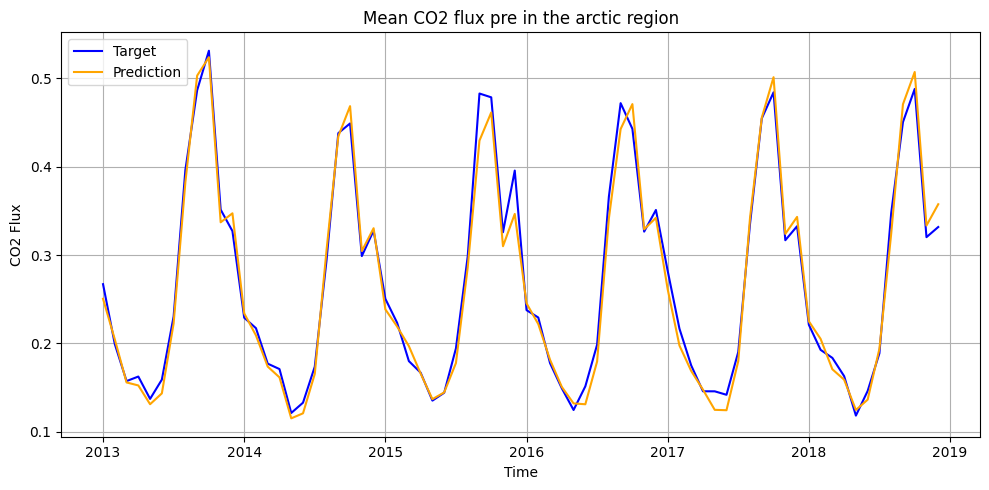

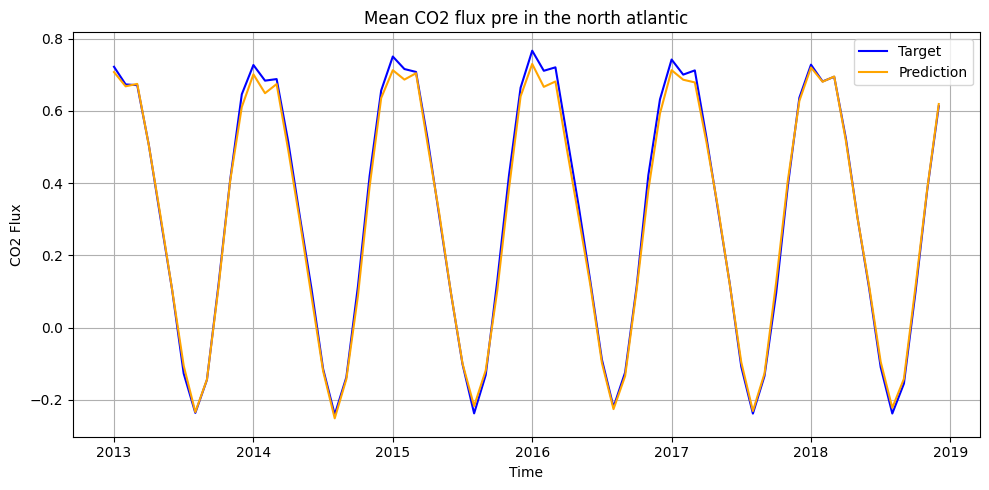

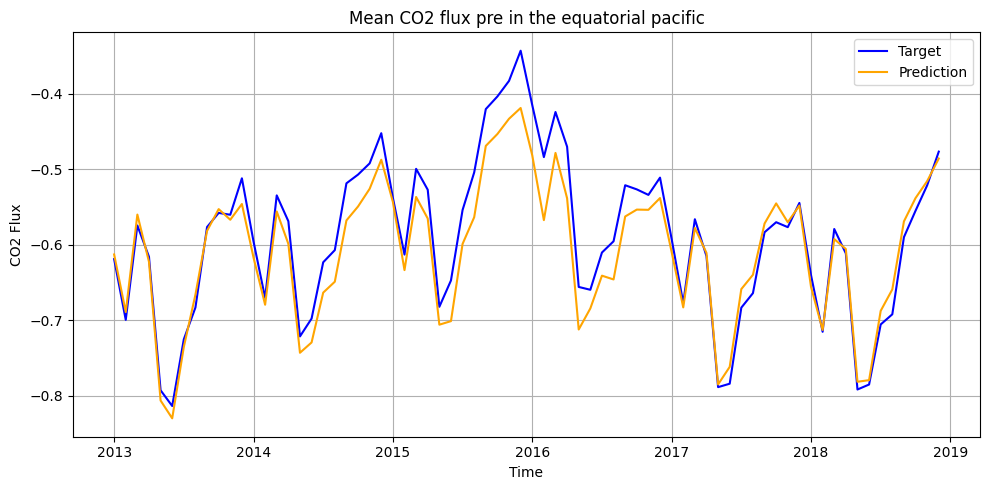

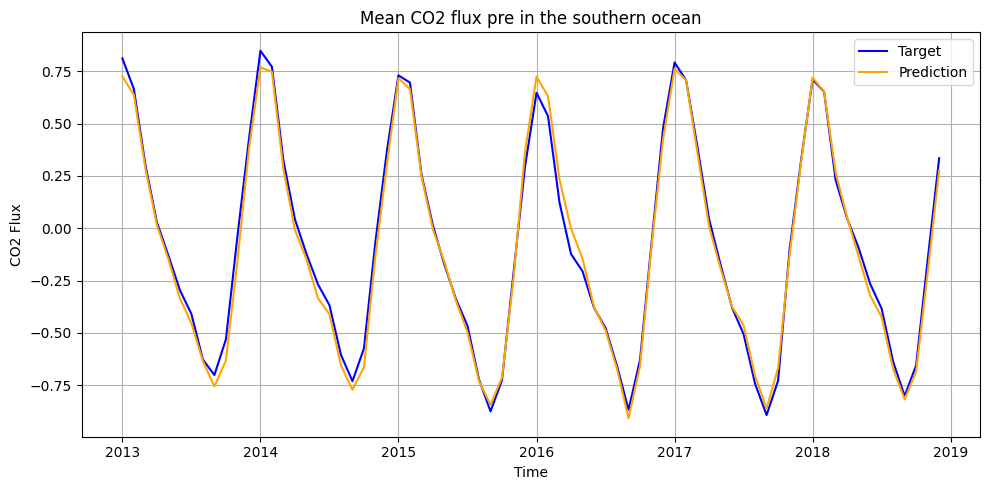

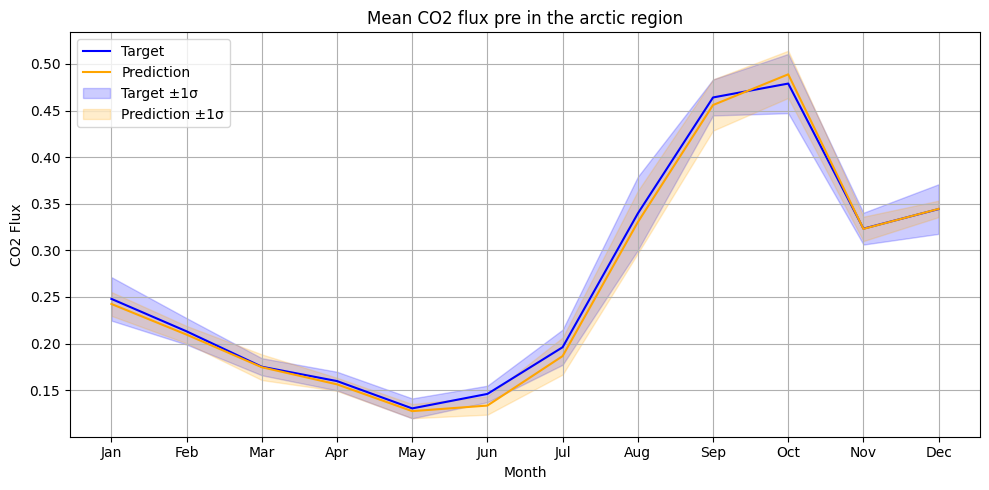

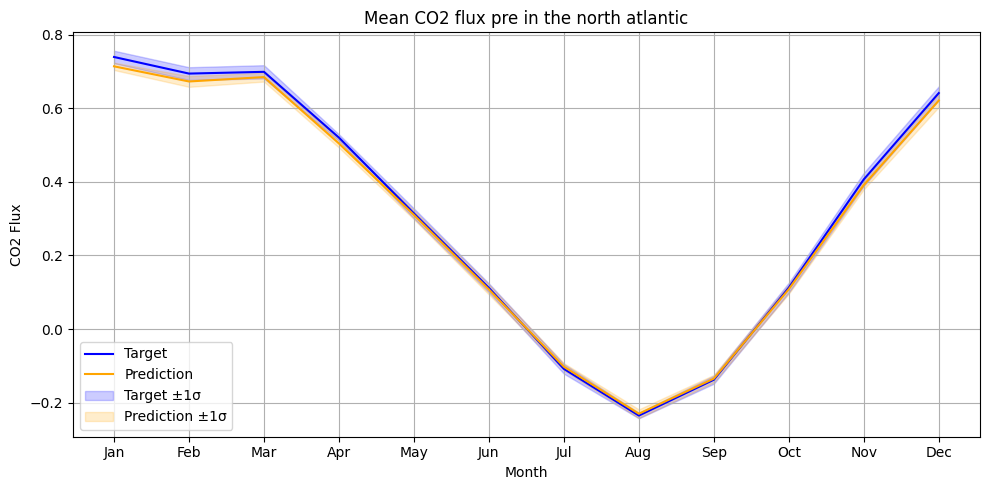

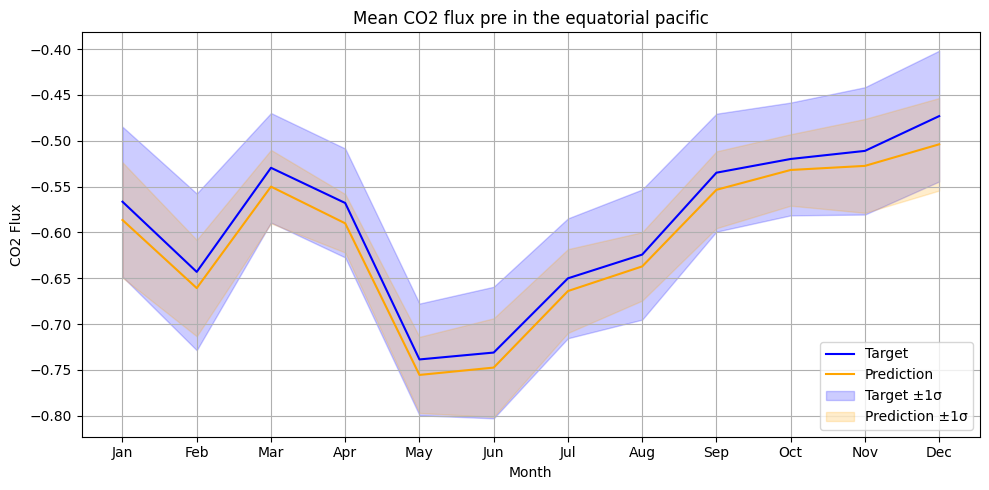

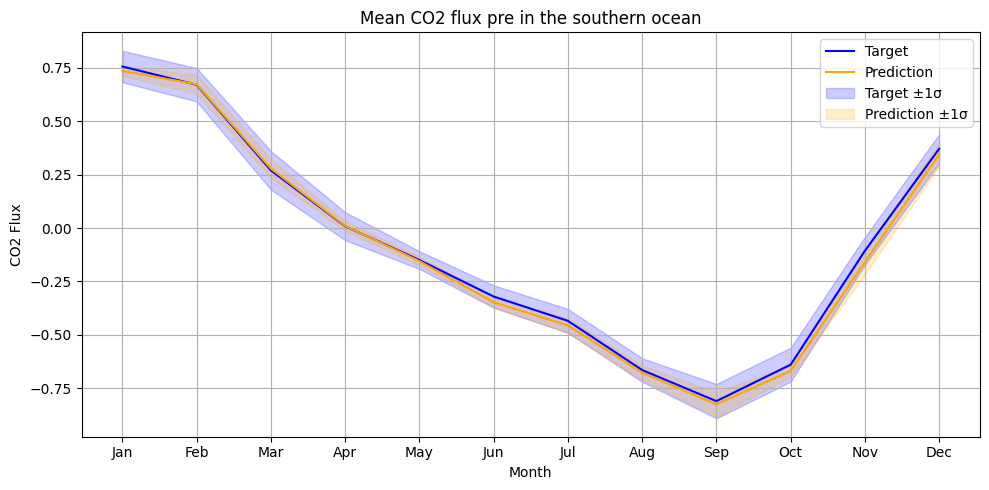

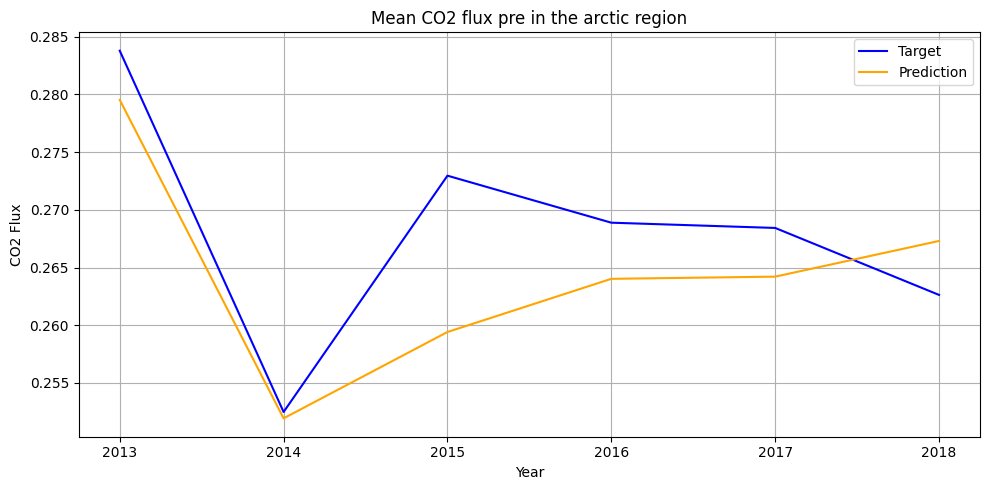

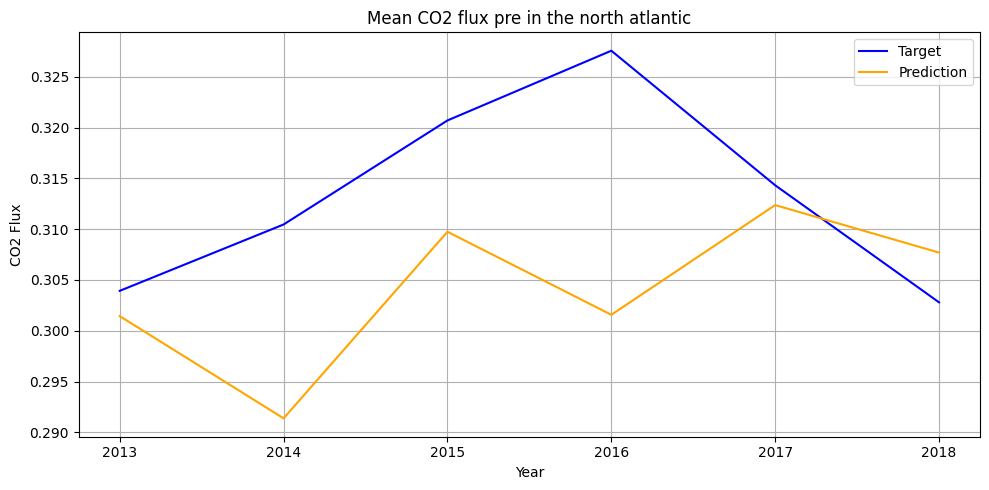

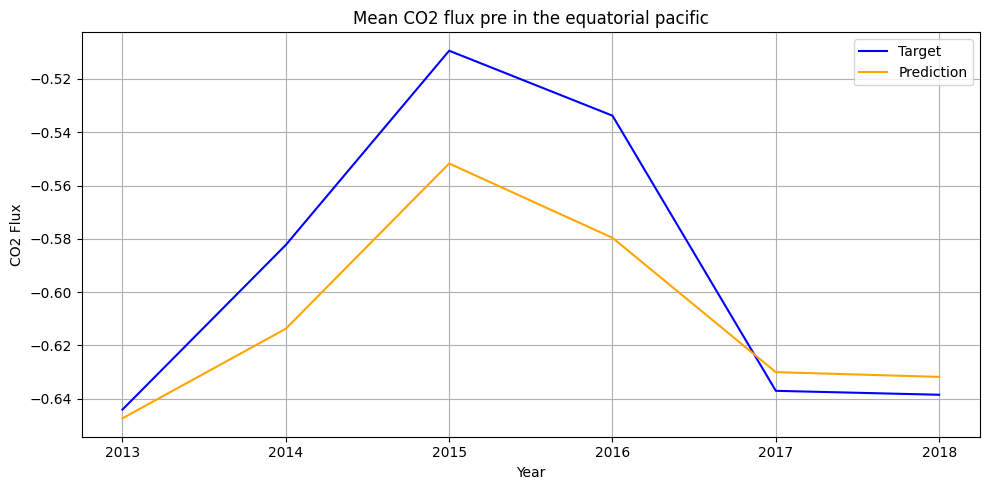

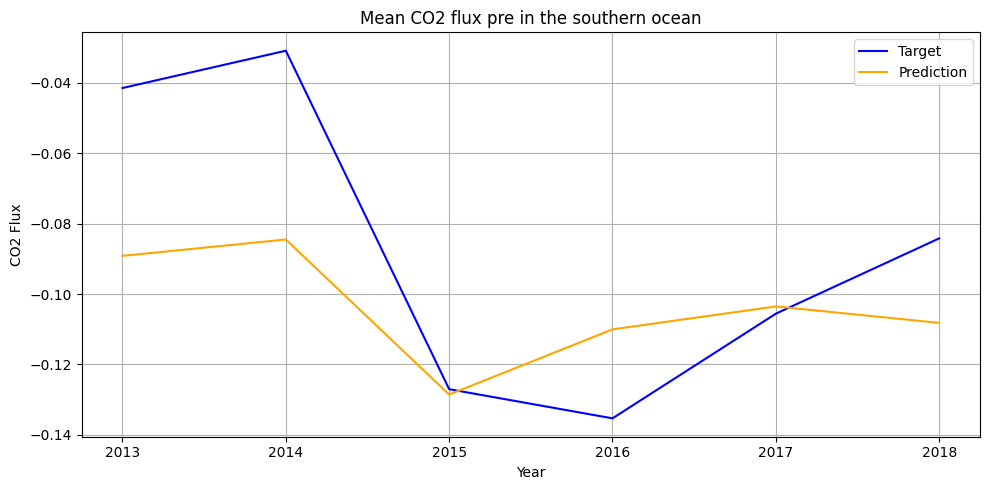

In [55]:
plot_timeseries_analysis(targets, test_reshaped, "ARCTIC", model_path, start_year)
plot_timeseries_analysis(targets, test_reshaped, "NORTH_ATLANTIC", model_path, start_year)
plot_timeseries_analysis(targets, test_reshaped, "EQ_PACIFIC", model_path, start_year)
plot_timeseries_analysis(targets, test_reshaped, "SOUTHERN_OCEAN", model_path, start_year)

plot_seasonal_analysis(targets, test_reshaped, "ARCTIC", model_path)
plot_seasonal_analysis(targets, test_reshaped, "NORTH_ATLANTIC", model_path)
plot_seasonal_analysis(targets, test_reshaped, "EQ_PACIFIC", model_path)
plot_seasonal_analysis(targets, test_reshaped, "SOUTHERN_OCEAN", model_path)

plot_yearly_analysis(targets, test_reshaped, "ARCTIC", model_path, start_year)
plot_yearly_analysis(targets, test_reshaped, "NORTH_ATLANTIC", model_path, start_year)
plot_yearly_analysis(targets, test_reshaped, "EQ_PACIFIC", model_path, start_year)
plot_yearly_analysis(targets, test_reshaped, "SOUTHERN_OCEAN", model_path, start_year)